In [115]:
import git
from pathlib import Path
import os
from PIL import Image
from scipy import ndimage
import numpy as np
import nibabel as nib
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes

ROOT_DIR = "/Users/hannahchung/Downloads/mri_testing/"
data_dir = os.path.join(ROOT_DIR, 'images')
output_dir = os.path.join(ROOT_DIR, 'images', 'cleaned')
os.makedirs(output_dir, exist_ok=True)

file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.nii.gz')]
file_names = [f for f in os.listdir(data_dir) if f.endswith('.nii.gz')]

print("Found files:", file_list)
file_names

Found files: ['/Users/hannahchung/Downloads/mri_testing/images/sub-009900_sub-009900_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-001303_sub-001303_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-001674_sub-001674_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-004840_sub-004840_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-004585_sub-004585_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-006448_sub-006448_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-007601_sub-007601_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-006356_sub-006356_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-005572_sub-005572_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-005324_sub-005324_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-000514_sub-000514_T1w.nii.gz', '/Users/hannahchung/Downloads/mri_testing/images/sub-005614_su

['sub-009900_sub-009900_T1w.nii.gz',
 'sub-001303_sub-001303_T1w.nii.gz',
 'sub-001674_sub-001674_T1w.nii.gz',
 'sub-004840_sub-004840_T1w.nii.gz',
 'sub-004585_sub-004585_T1w.nii.gz',
 'sub-006448_sub-006448_T1w.nii.gz',
 'sub-007601_sub-007601_T1w.nii.gz',
 'sub-006356_sub-006356_T1w.nii.gz',
 'sub-005572_sub-005572_T1w.nii.gz',
 'sub-005324_sub-005324_T1w.nii.gz',
 'sub-000514_sub-000514_T1w.nii.gz',
 'sub-005614_sub-005614_T1w.nii.gz',
 'sub-005042_sub-005042_T1w.nii.gz',
 'sub-009136_sub-009136_T1w.nii.gz',
 'sub-002961_sub-002961_T1w.nii.gz',
 'sub-007521_sub-007521_T1w.nii.gz',
 'sub-006798_sub-006798_T1w.nii.gz',
 'sub-007809_sub-007809_T1w.nii.gz',
 'sub-003573_sub-003573_T1w.nii.gz',
 'sub-009342_sub-009342_T1w.nii.gz',
 'sub-010249_sub-010249_T1w.nii.gz',
 'sub-003772_sub-003772_T1w.nii.gz',
 'sub-000807_sub-000807_T1w.nii.gz',
 'sub-008874_sub-008874_T1w.nii.gz',
 'sub-008826_sub-008826_T1w.nii.gz',
 'sub-008632_sub-008632_T1w.nii.gz',
 'sub-005439_sub-005439_T1w.nii.gz',
 

## EDA

Where is the expected bottom slice?

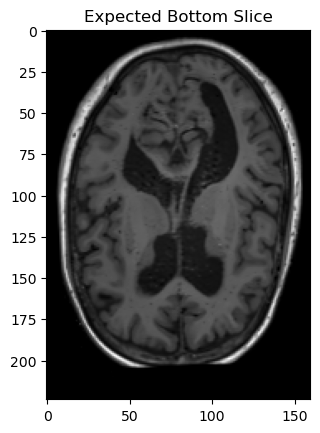

In [135]:
volume = nib.load(file_list[2]).get_fdata()
plt.imshow(volume[:, :, -100].T, cmap="gray")
plt.title("Expected Bottom Slice")
plt.show()

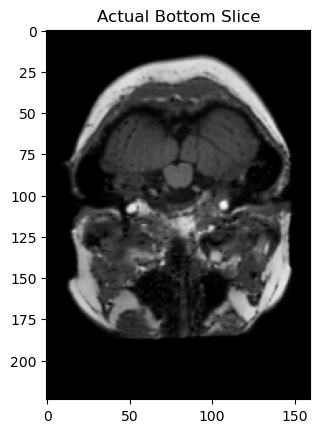

In [35]:
plt.imshow(volume[:, :, 0].T, cmap="gray")  
plt.title("Actual Bottom Slice")
plt.show()

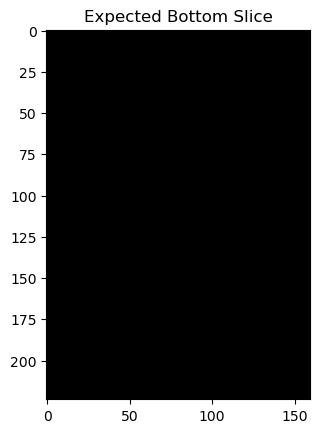

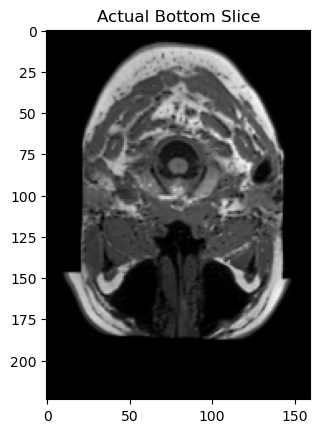

In [36]:
volume = nib.load(file_list[80]).get_fdata()
plt.imshow(volume[:, :, -1].T, cmap="gray")
plt.title("Expected Bottom Slice")
plt.show()

plt.imshow(volume[:, :, 0].T, cmap="gray")  
plt.title("Actual Bottom Slice")
plt.show()

## Visualizing Layout

In [37]:
volume = nib.load(file_list[2])  # Load the NIfTI file
print(volume.affine)

[[  -1.            0.            0.           96.48149872]
 [   0.            1.            0.         -141.47715759]
 [   0.            0.            1.         -156.55375671]
 [   0.            0.            0.            1.        ]]


##### The affine matrix's fourth column represents the real-world coordinates of the voxel (0,0,0). The negative value in the Z-axis row indicates that Z=0 corresponds to the brainstem. As voxel indices increase in Z, we move upward in the real-world coordinate space. 

The first row, which corresponds to the X-axis, has a negative value, meaning left and right are flipped. This follows the radiological convention, where the left side of the image corresponds to the right side of the patient’s brain. 

/var/folders/cg/nwm9l18x22zc8_fj15gvgg2h0000gp/T/ipykernel_62706/932394000.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


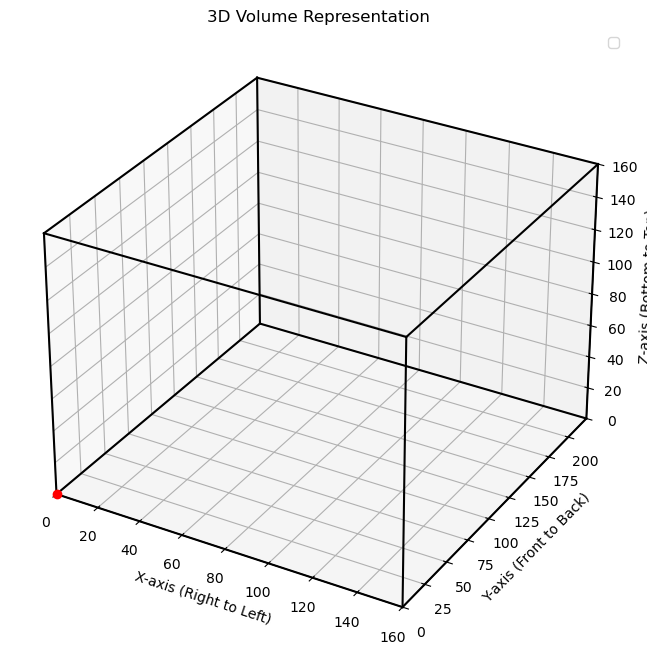

In [38]:
sample = nib.load(file_list[2])
shape_x = volume.shape[0]
shape_y = volume.shape[1]
shape_z = volume.shape[2]


edges = np.array([
    [0, 0, 0], [shape_x, 0, 0], [shape_x, shape_y, 0], [0, shape_y, 0],
    [0, 0, shape_z], [shape_x, 0, shape_z], [shape_x, shape_y, shape_z], [0, shape_y, shape_z]
])


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    ax.plot(*zip(*[edges[i], edges[(i + 1) % 4]]), color="black")
    ax.plot(*zip(*[edges[i + 4], edges[(i + 1) % 4 + 4]]), color="black")
    ax.plot(*zip(*[edges[i], edges[i + 4]]), color="black") 



plt.plot(0, 0, 0, "ro")

ax.set_xlabel("X-axis (Right to Left)")
ax.set_ylabel("Y-axis (Front to Back)")
ax.set_zlabel("Z-axis (Bottom to Top)")
ax.set_xlim([0, shape_x])
ax.set_ylim([0, shape_y])
ax.set_zlim([0, shape_z])
ax.set_title("3D Volume Representation")

ax.legend()
plt.show()


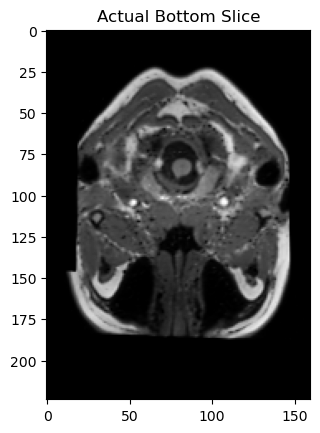

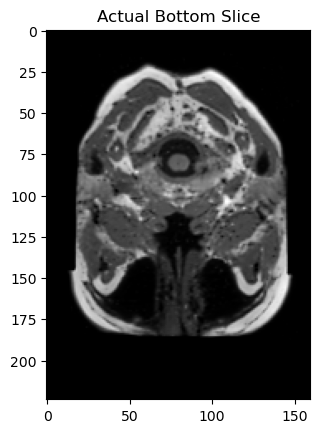

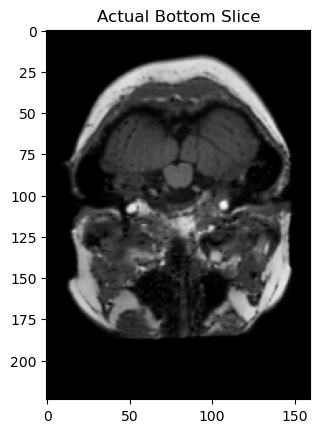

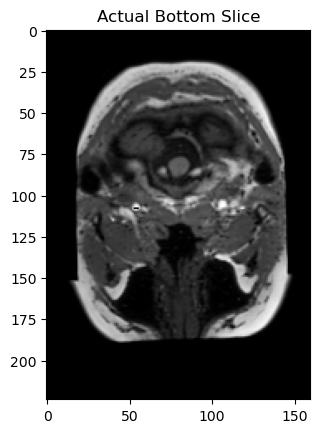

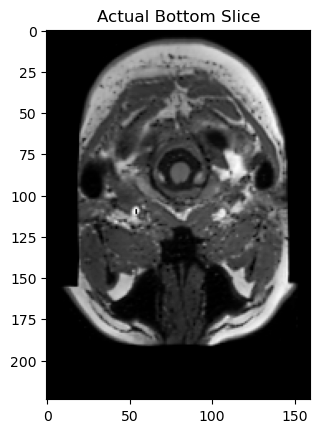

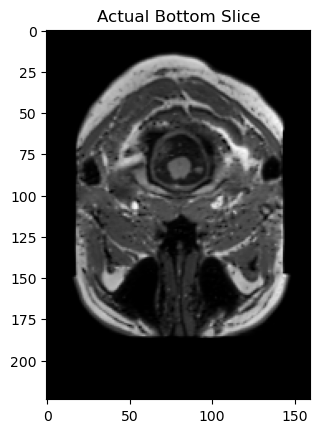

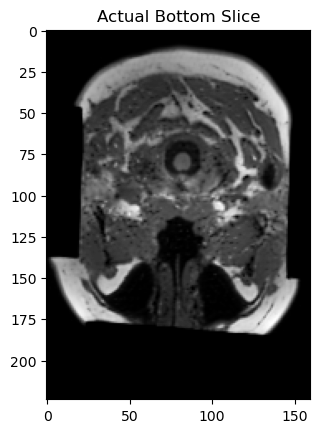

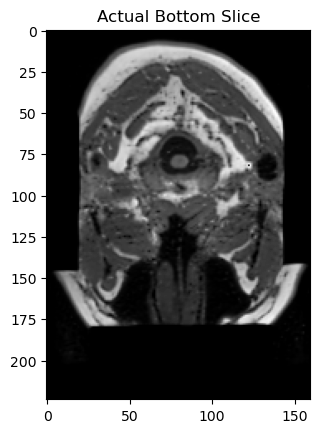

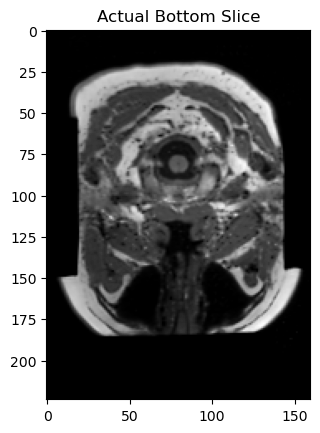

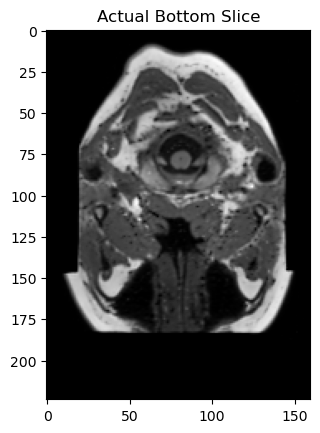

In [39]:
for i in range(10):
    volume = nib.load(file_list[i]).get_fdata()
    plt.imshow(volume[:, :, 0].T, cmap="gray")  
    plt.title("Actual Bottom Slice")
    plt.show()

### Filter function

Creates copy of input, adds plane at Z = 0 with high-intensity value (5000), which seals the brain at the bottom. Applies binary_fill_holes, then removes the bottom plane. Binary mask created, with false values being assigned to NaN.

In [116]:
def filter(volume):
    volume_copy = volume.copy().astype(np.float32)
    volume_with_plane = np.concatenate(
        (np.full((volume_copy.shape[0], volume_copy.shape[1], 1), 5000), volume_copy), axis=2
    )

    volume_fill = binary_fill_holes(volume_with_plane).astype(bool)
    volume_fill = volume_fill[:, :, 1:]
    
    binary_mask = ~volume_fill
    volume_copy[binary_mask] = np.nan

    return volume_copy


PIL does not support 3D

In [118]:
for i in tqdm(range(len(file_list))):
    file_path = file_list[i]
    volume = nib.load(file_path).get_fdata()
    #normalized_volume = normalize_to_L(volume)
    filtered_volume = filter(volume)
    

    base_name = file_names[i].replace('.nii.gz', '_cleaned.npz')
    save_path = os.path.join(output_dir, base_name)
    np.savez(save_path, filtered_volume)

print("✅ All MRI volumes processed and saved as .npz arrays.")


100%|██████████| 100/100 [00:31<00:00,  3.19it/s]

✅ All MRI volumes processed and saved as .npz arrays.


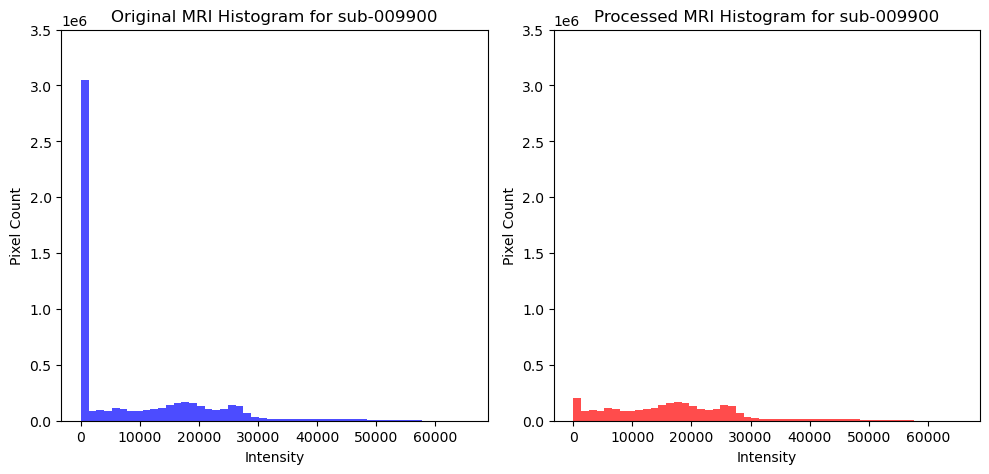

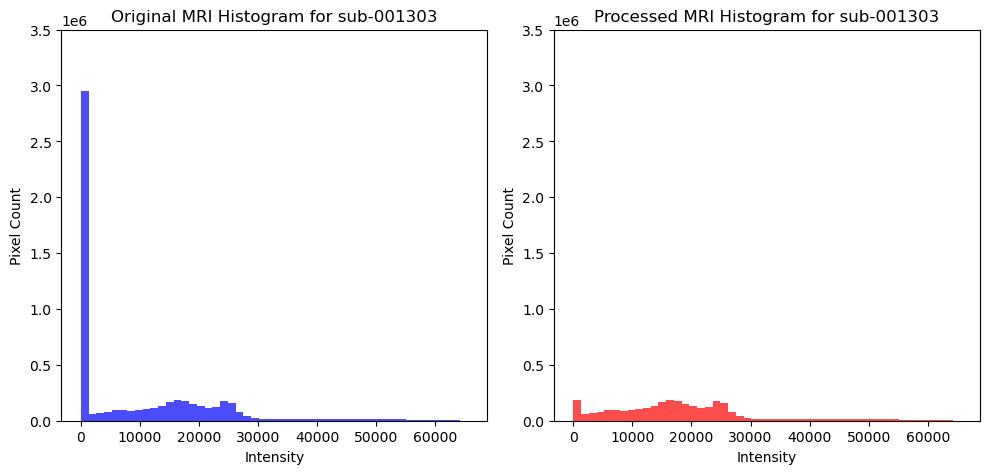

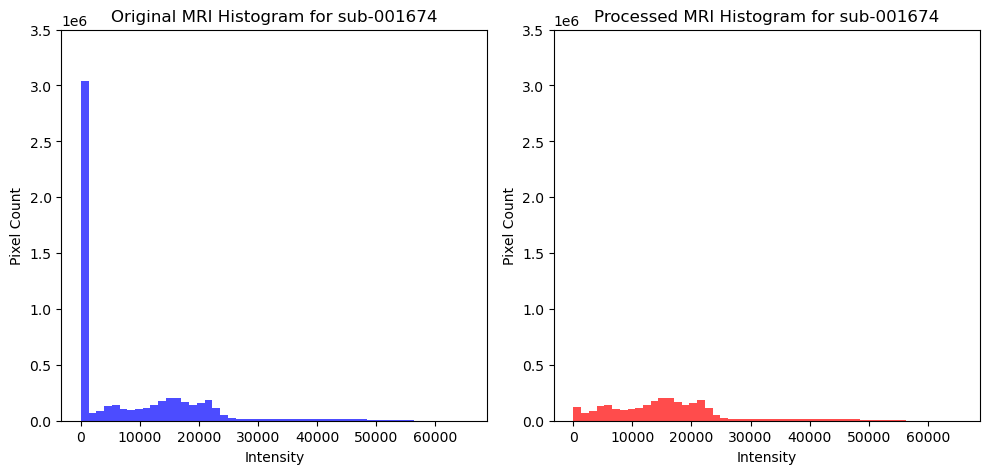

In [136]:
n = 3
for i in range(n):
    file_path = file_list[i]
    original_volume = nib.load(file_path).get_fdata()
    #original_volume = normalize_to_L(original_volume)

    processed_path = os.path.join(output_dir, file_names[i].replace('.nii.gz', '_cleaned.npz'))
    processed_volume = np.load(processed_path)["arr_0"]
    

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(original_volume.flatten(), bins=50, color="blue", alpha=0.7)
    plt.title(f"Original MRI Histogram for {file_names[i].split('_')[0]}")
    plt.xlabel("Intensity")
    plt.ylabel("Pixel Count")
    plt.ylim(0, 3500000)

    plt.subplot(1, 2, 2)
    plt.hist(processed_volume.flatten(), bins=50, color="red", alpha=0.7)
    plt.title(f"Processed MRI Histogram for {file_names[i].split('_')[0]}")
    plt.xlabel("Intensity")
    plt.ylabel("Pixel Count")
    plt.ylim(0, 3500000)

    plt.tight_layout()
    plt.show()

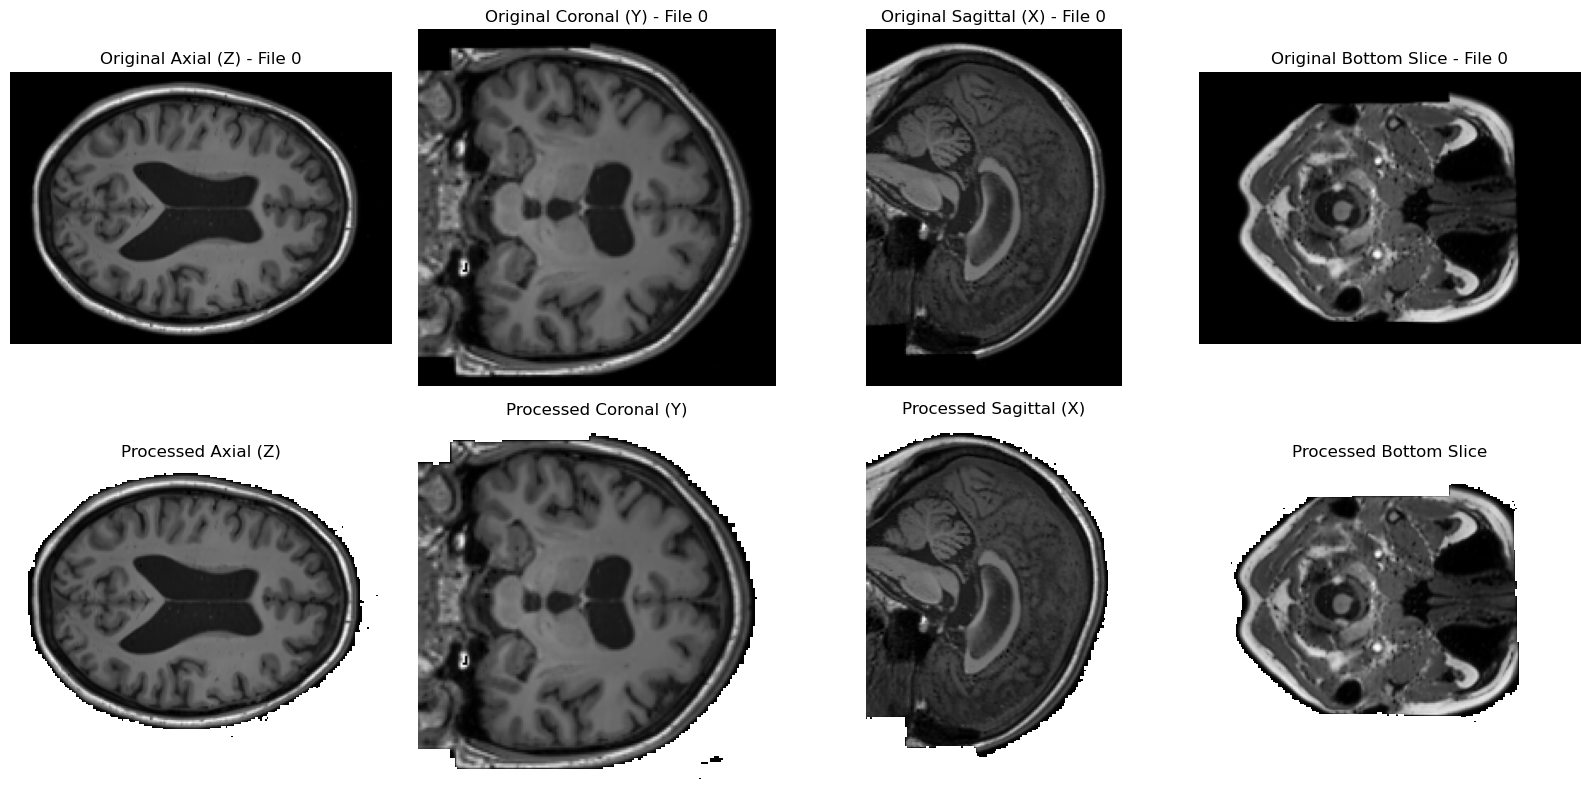

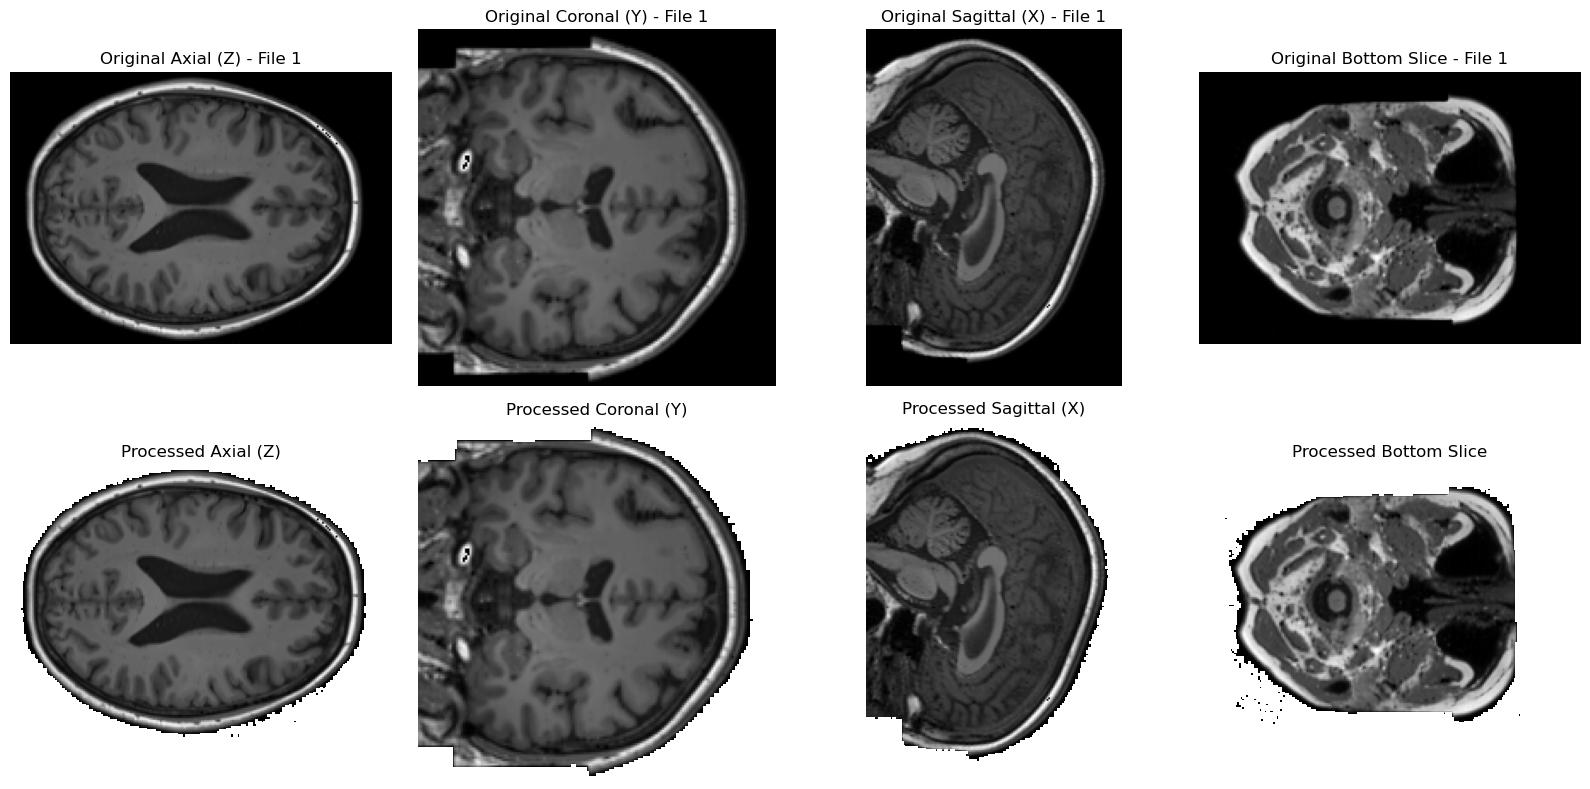

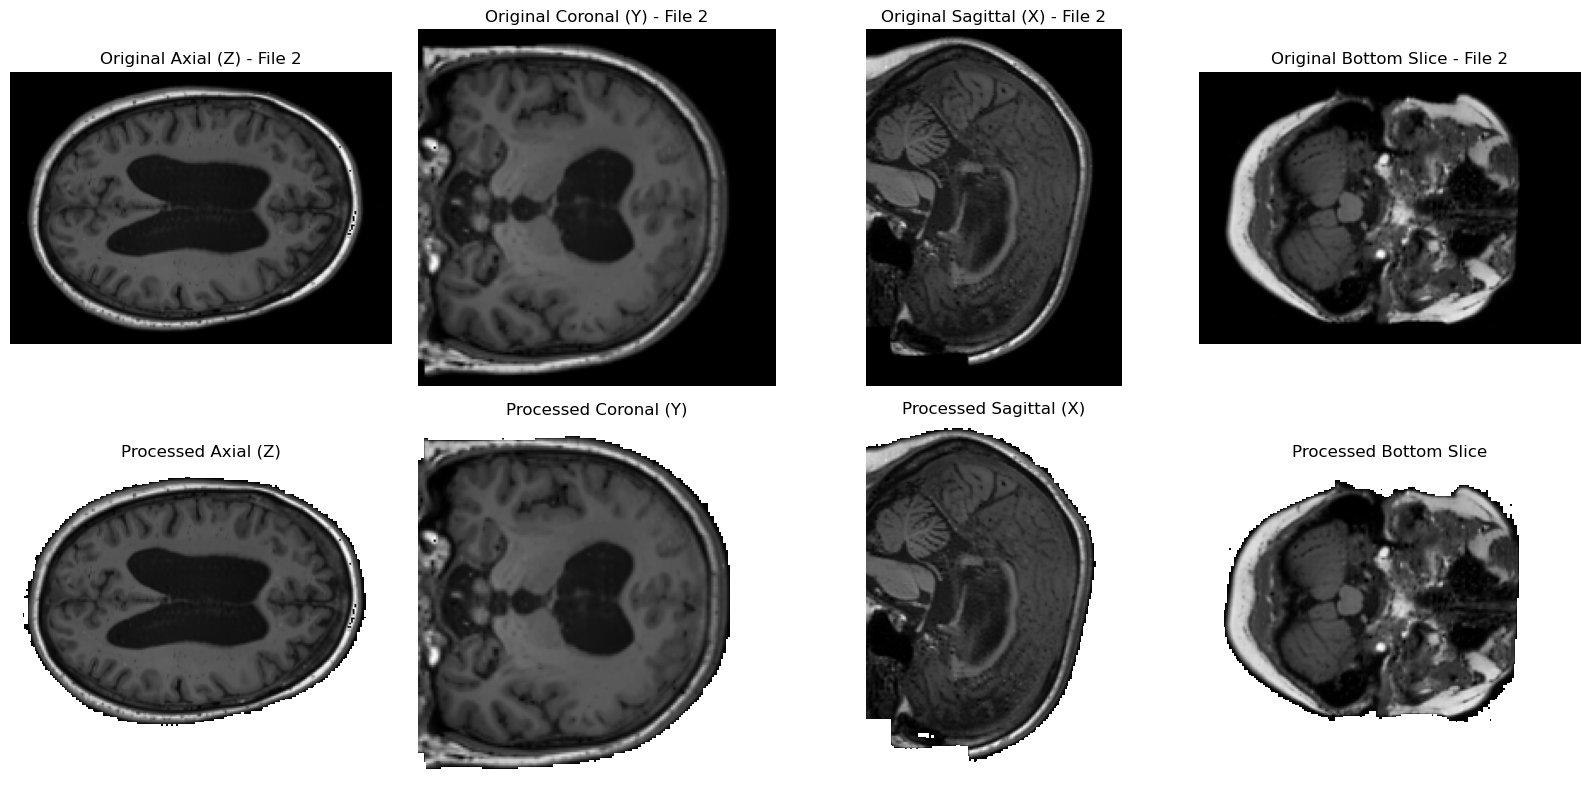

In [ ]:
n = 3  

for i in range(n):
    file_path = file_list[i]
    original_volume = nib.load(file_path).get_fdata()
    
    processed_path = os.path.join(output_dir, file_names[i].replace('.nii.gz', '_cleaned.npz'))
    processed_volume = np.load(processed_path)["arr_0"]

    mid_z = original_volume.shape[2] // 2
    mid_y = original_volume.shape[1] // 2
    mid_x = original_volume.shape[0] // 2  
    bottom_z = 0

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    axes[0, 0].imshow(original_volume[:, :, mid_z], cmap="gray")
    axes[0, 0].set_title(f"Original Axial (Z) - File {i}")

    axes[0, 1].imshow(original_volume[:, mid_y, :], cmap="gray")
    axes[0, 1].set_title(f"Original Coronal (Y) - File {i}")

    axes[0, 2].imshow(original_volume[mid_x, :, :], cmap="gray")
    axes[0, 2].set_title(f"Original Sagittal (X) - File {i}")

    axes[0, 3].imshow(original_volume[:, :, bottom_z], cmap="gray")
    axes[0, 3].set_title(f"Original Bottom Slice - File {i}")

    axes[1, 0].imshow(processed_volume[:, :, mid_z], cmap="gray")
    axes[1, 0].set_title("Processed Axial (Z)")

    axes[1, 1].imshow(processed_volume[:, mid_y, :], cmap="gray")
    axes[1, 1].set_title("Processed Coronal (Y)")

    axes[1, 2].imshow(processed_volume[mid_x, :, :], cmap="gray")
    axes[1, 2].set_title("Processed Sagittal (X)")

    axes[1, 3].imshow(processed_volume[:, :, bottom_z], cmap="gray")
    axes[1, 3].set_title("Processed Bottom Slice")

    for ax in axes.ravel():
        ax.axis("off")

    plt.tight_layout()
    plt.show()


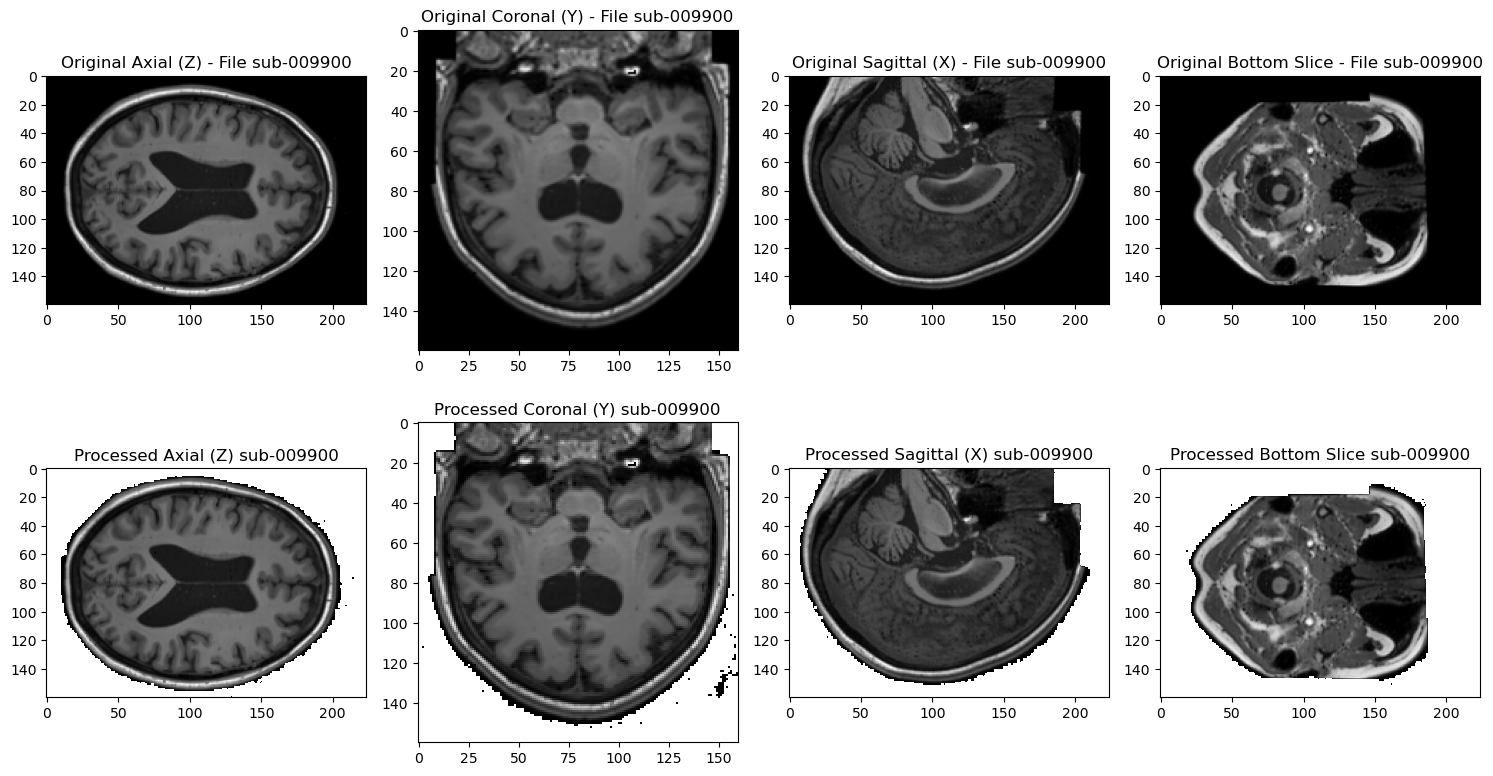

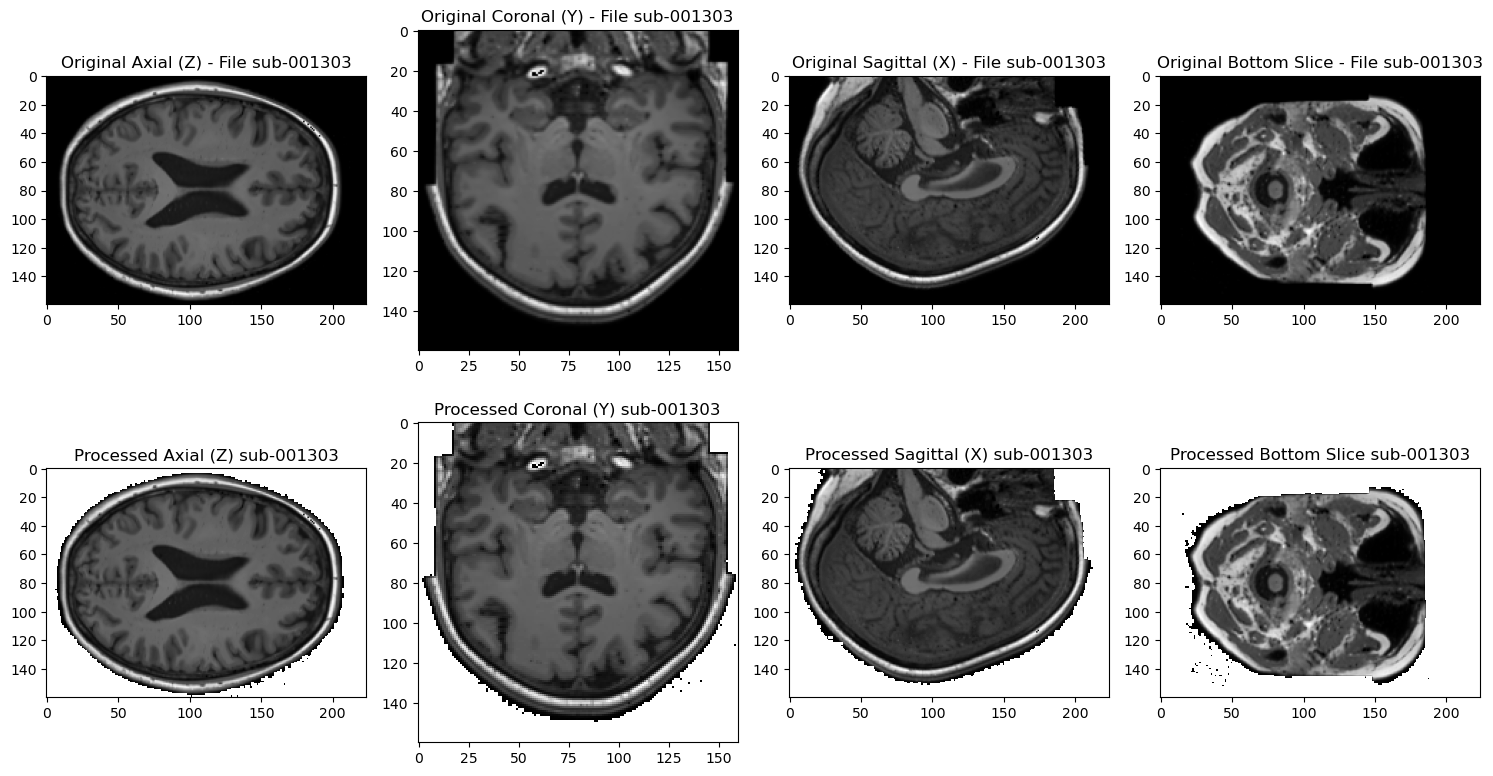

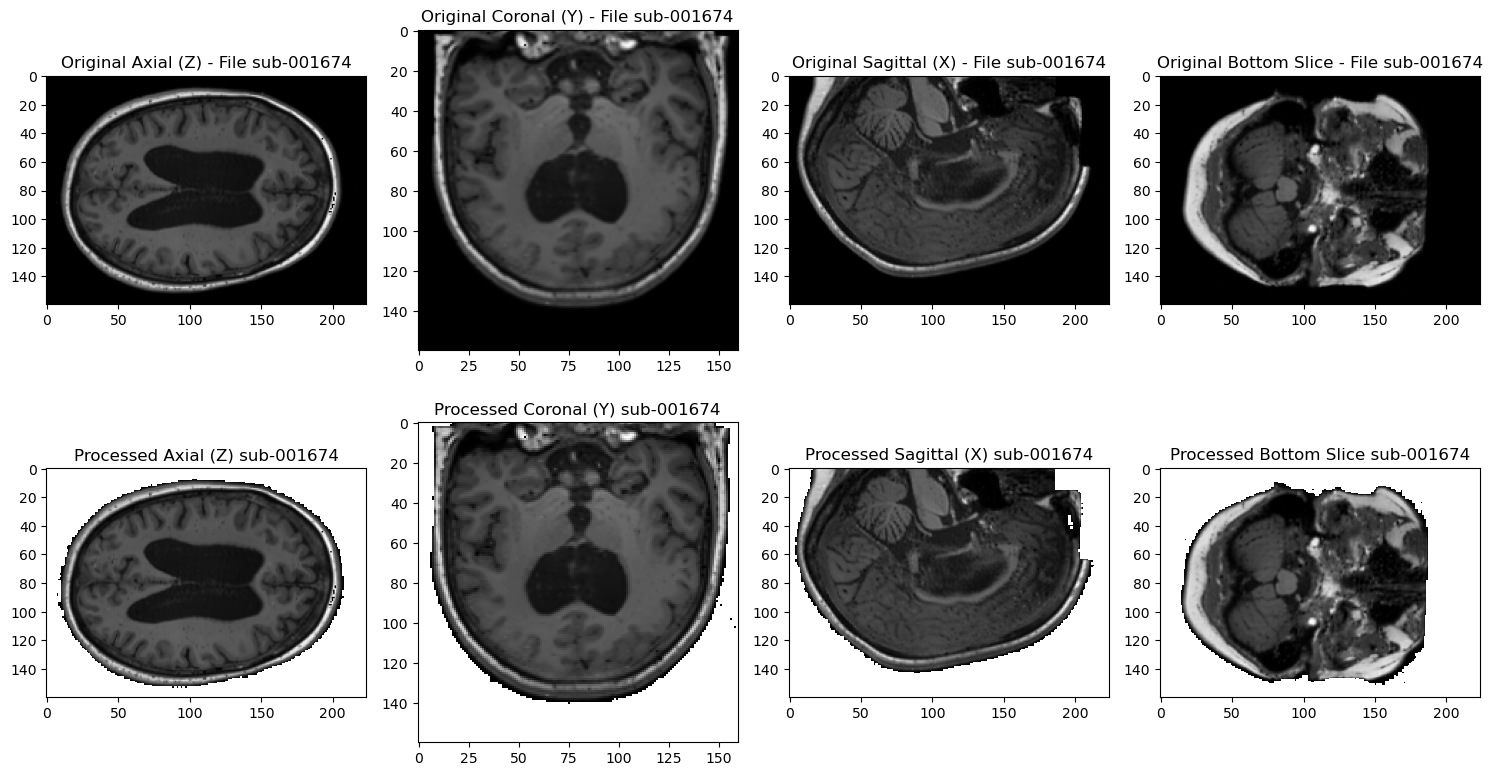

In [129]:
n = 3
for i in range(n):
    file_path = file_list[i]
    original_volume = nib.load(file_path).get_fdata()

    processed_path = os.path.join(output_dir, file_names[i].replace('.nii.gz', '_cleaned.npz'))
    processed_volume = np.load(processed_path)["arr_0"]

    mid_x = original_volume.shape[0] // 2
    mid_y = original_volume.shape[1] // 2
    mid_z = original_volume.shape[2] // 2
    bottom_z = 0

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))

    axes[0, 0].imshow(original_volume[:, :, mid_z], cmap="gray")
    axes[0, 0].set_title(f"Original Axial (Z) - File {file_names[i].split('_')[0]}")

    axes[0, 1].imshow(original_volume[:, mid_y, :].T, cmap="gray")
    axes[0, 1].set_title(f"Original Coronal (Y) - File {file_names[i].split('_')[0]}")

    axes[0, 2].imshow(original_volume[mid_x, :, :].T, cmap="gray")
    axes[0, 2].set_title(f"Original Sagittal (X) - File {file_names[i].split('_')[0]}")

    axes[0, 3].imshow(original_volume[:, :, bottom_z], cmap="gray")
    axes[0, 3].set_title(f"Original Bottom Slice - File {file_names[i].split('_')[0]}")

    axes[1, 0].imshow(processed_volume[:, :, mid_z], cmap="gray")
    axes[1, 0].set_title(f"Processed Axial (Z) {file_names[i].split('_')[0]}")

    axes[1, 1].imshow(processed_volume[:, mid_y, :].T, cmap="gray")
    axes[1, 1].set_title(f"Processed Coronal (Y) {file_names[i].split('_')[0]}")

    axes[1, 2].imshow(processed_volume[mid_x, :, :].T, cmap="gray")
    axes[1, 2].set_title(f"Processed Sagittal (X) {file_names[i].split('_')[0]}")

    axes[1, 3].imshow(processed_volume[:, :, bottom_z], cmap="gray")
    axes[1, 3].set_title(f"Processed Bottom Slice {file_names[i].split('_')[0]}")

    plt.tight_layout()
    plt.show()


Add normalization step after

In [73]:
n = 3  # Number of files to check

for i in range(n):
    processed_path = os.path.join(output_dir, file_names[i].replace('.nii.gz', '_cleaned.npz'))
    processed_data = np.load(processed_path)

    # Print the stored arrays in the npz file
    print(f"\n🔍 File: {file_names[i]}")
    print(f"Stored Arrays: {processed_data.files}")  # Should show ['arr_0'] or custom key
    print(f"Shape: {processed_data['arr_0'].shape}")
    print(f"Data Type: {processed_data['arr_0'].dtype}")
    print(f"Min: {np.nanmin(processed_data['arr_0'])}, Max: {np.nanmax(processed_data['arr_0'])}")


🔍 File: sub-009900_sub-009900_T1w.nii.gz
Stored Arrays: ['arr_0']
Shape: (160, 224, 160)
Data Type: float32
Min: 0.0, Max: 65532.0

🔍 File: sub-001303_sub-001303_T1w.nii.gz
Stored Arrays: ['arr_0']
Shape: (160, 224, 160)
Data Type: float32
Min: 0.0, Max: 65535.0

🔍 File: sub-001674_sub-001674_T1w.nii.gz
Stored Arrays: ['arr_0']
Shape: (160, 224, 160)
Data Type: float32
Min: 0.0, Max: 65534.0


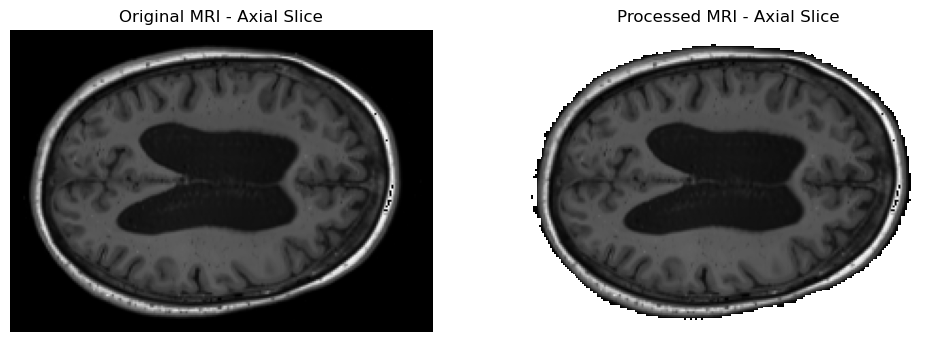

In [126]:

file_path = file_list[2]
original_volume = nib.load(file_path).get_fdata()

# Load the processed (cleaned) MRI
processed_path = os.path.join(output_dir, file_names[2].replace('.nii.gz', '_cleaned.npz'))
processed_volume = np.load(processed_path)["arr_0"]

# Select a middle slice (axial view)
middle_slice = original_volume.shape[2] // 2

# Plot the original vs. processed MRI slice
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_volume[:, :, middle_slice], cmap="gray")
plt.title("Original MRI - Axial Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(processed_volume[:, :, middle_slice], cmap="gray")
plt.title("Processed MRI - Axial Slice")
plt.axis("off")

plt.show()

In [ ]:
# def normalize_to_L(volume):
#     min_val = np.min(volume)
#     max_val = np.max(volume)

#     volume = (volume - min_val) / (max_val - min_val)
#     volume = (volume * 255).astype(np.uint8)
    
#     return volume
